In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import torch

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from copy import deepcopy
from pmdarima.arima import auto_arima
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Data Preparation

### Deskripsi Data
1. Tanggal -> Waktu data diambil
2. Temperature Maksimum -> Suhu maksimum dalam derajat celcius

In [2]:
df = pd.read_excel('2. Data Temperatur Maksimum.xlsx')
df.rename(columns={'Tanggal':'T', 'Temperatur Maksimum (°C)':'C'}, inplace=True)
df.head()

,T,C
0,2005-01-01,27.8
1,2005-01-02,29.1
2,2005-01-03,28.6
3,2005-01-04,28.4
4,2005-01-05,27.8


In [3]:
# Memeriksa missing value
df.isnull().sum()

T    0
C    4
dtype: int64

In [6]:
# mengisi nilai yang null dengan rata-rata
df['C'] = df['C'].fillna(df['C'].mean())
df.isnull().sum()

T    0
C    0
dtype: int64

# Plot Data

In [7]:
# Plot time series
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['T'], y=df['C'],
                    mode='lines',
                    name='lines')
              )

fig.update_layout(
    title='Time Series Data Temperature',
    xaxis_title='Tanggal',
    yaxis_title='Temperatur Maksimum (°C)',
    width=1000,
    height=500,
    template='plotly_white'
)

fig.show()

In [9]:
# Rolling mean dan rolling std
df['Rolling Mean'] = df['C'].rolling(window=12).mean()
df['Rolling Std'] = df['C'].rolling(window=12).std()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['T'], y=df['C'],
                    mode='lines',
                    name='Orginal Data',
                    )
              )

fig.add_trace(go.Scatter(x=df['T'], y=df['Rolling Mean'],
                    mode='lines',
                    name='Rolling Mean')
              )

fig.add_trace(go.Scatter(x=df['T'], y=df['Rolling Std'],
                    mode='lines',
                    name='Rolling Std')
              )

fig.update_layout(
    title='Time Series Data Temperature',
    xaxis_title='Tanggal',
    yaxis_title='Temperature (°C)',
    width=1000,
    height=500,
    template='plotly_white'
)

fig.show()

print('Rata-rata rolling mean: ', df['Rolling Mean'].mean())
print('Rata-rata rolling std: ', df['Rolling Std'].mean())

Rata-rata rolling mean:  28.91788086343603
Rata-rata rolling std:  1.15771440839993


# Uji ADF

In [10]:
# Uji kestasioneran data menggunakan uji ADF (Augmented Dickey-Fuller)
adf = adfuller(df['C'], autolag='AIC')
print('ADF Statistic: ', adf[0])
print('p-value: ', adf[1])
if adf[1] < 0.05:
    print('Data stasioner berdasarkan p-value')
else:
    print('Data tidak stasioner berdasarkan p-value')
    
print()
    
print('Critical Values:')
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
    if adf[0] < value:
        print('Data stasioner berdasarkan critical value')
    else:
        print('Data tidak stasioner berdasarkan critical value')


ADF Statistic:  -6.963395029550493
p-value:  9.04308279414727e-10
Data stasioner berdasarkan p-value

Critical Values:
	1%: -3.432
Data stasioner berdasarkan critical value
	5%: -2.862
Data stasioner berdasarkan critical value
	10%: -2.567
Data stasioner berdasarkan critical value


Karena data sudah stasioner, maka tidak diperlukan proses differencing. <br>
Data diatas menunjukkan nilai p-value yang lebih kecil dari 0.05, sehingga data tersebut stasioner. Dan dari data menujukkan bahwa nilai ADF < nilai kritis, sehingga data tersebut stasioner.

# Plot ACF dan PACF

<strong>ACF:</strong> plot dari korelasi antara data pada suatu lag dengan data pada lag yang sebelumnya<br>
<strong>PACF:</strong> plot dari korelasi antara data pada suatu lag dengan data pada lag sebelumnya setelah menghapus pengaruh lag-lag yang berada diantara keduanya

## Pemilihan Model Time Series

### Model AR
- Pilih model AR jika ACF menunjukkan pola eksponensial yang mendekati 0
- Orde AR(p) dapat diidentifikasi dari PACF yang mengalami cutoff setelah lag tertentu
<br>

### Model MA
- Pilih model MA jika ACF menunjukkan pola yang mengalami cutoff setelah lag tertentu
- Orde MA(q) dapat diidentifikasi dari ACF yang mengalami cutoff setelah lag tertentu

### Model ARMA
- Pilih model ARMA jika ACF dan PACF menunjukkan pola yang mendekati 0 dan mengalami cutoff setelah lag tertentu
- Menentukan orde AR dan MA dengan melihat ACF dan PACF

### Model ARIMA
- Pilih model ARIMA(p, d, q) jika data tidak stasioner (d > 0) dan ACF serta PACF menunjukkan pola yang mendekati 0 dan mengalami cut-off setelah lag tertentu.
- Orde differencing (d) bisa diidentifikasi berdasarkan berapa kali differencing yang diperlukan untuk menjadikan data stasioner.
- Orde AR (p) dan orde MA (q) dapat diidentifikasi dari plot ACF dan PACF dari data yang telah di-differencing.

,ACF,PACF
1,1.000000,1.000000
2,0.575750,0.575932
3,0.476355,0.216906
4,0.405030,0.102872
5,0.388989,0.119280
6,0.358456,0.068572
7,0.326854,0.039241
8,0.304433,0.037796
9,0.290326,0.038364
10,0.287260,0.048545


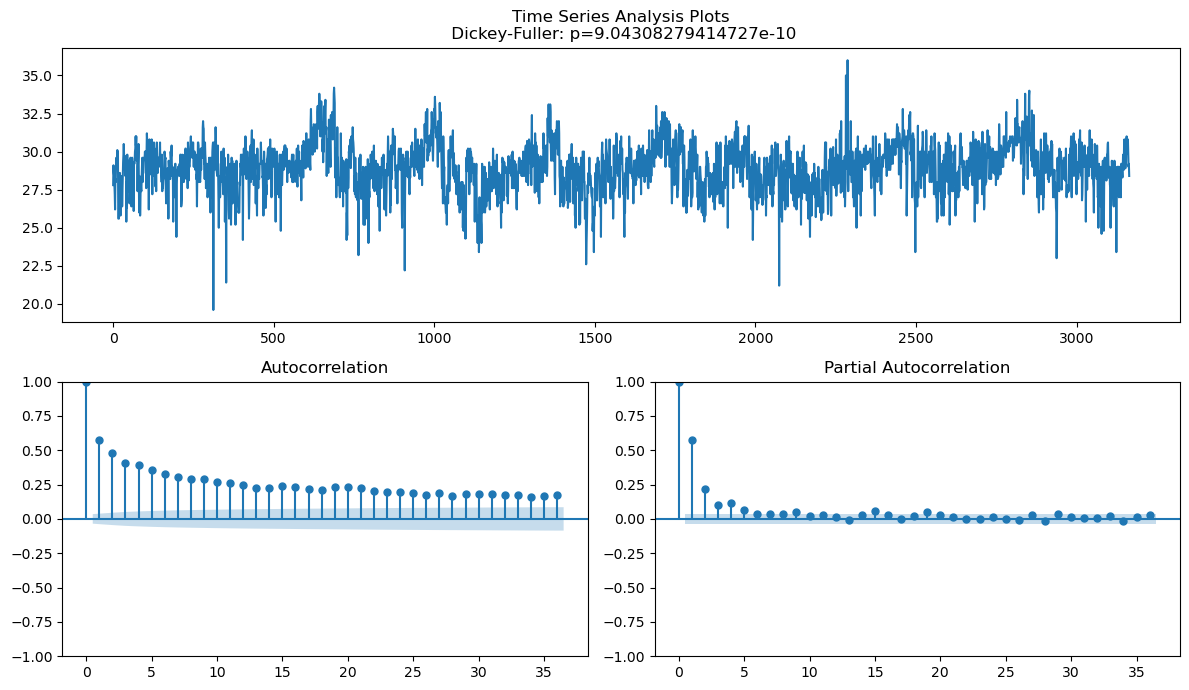

In [11]:
# ACF dan PACF plot
fig = plt.figure(figsize=(12, 7))
ts_ax = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=2)
acf_ax = plt.subplot2grid(shape=(2, 2), loc=(1, 0))
pacf_ax = plt.subplot2grid(shape=(2, 2), loc=(1, 1))

df['C'].plot(ax=ts_ax)
p_value = adfuller(df['C'], autolag='AIC')[1]
ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={}'.format(p_value))
plot_acf(df['C'], lags=None, ax=acf_ax)
plot_pacf(df['C'], lags=None, ax=pacf_ax)
plt.tight_layout()

# Mengoutputkan nilai ACF dan PACF dari library acf dan pacf
test_df = pd.DataFrame([acf(df['C'])[0:15], 
                        pacf(df['C'])[0:15]]).T
test_df.columns = ['ACF', 'PACF']
test_df.index += 1
test_df

Berdasarkan hasil visualisasi, pacf mengalami cutoff setelah lag 5, dan acf mengalami penurunan secara eksponensial setelah lag ke 2, maka model yang digunakan adalah ARMA(2, 5) atau ARIMA(2, 0, 5)

# Identifikasi ARMA(2, 5)

In [12]:
# Jika menggunakan auto arima
auto_arima(df['C'], 
           seasonal=False, 
           stationary=True, 
           trace=True, 
           error_action='ignore', 
           suppress_warnings=True, 
           information_criterion='aic').summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10397.343, Time=2.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=11893.535, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10621.090, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=11105.448, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30290.369, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=10373.861, Time=1.82 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=10783.908, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10394.061, Time=1.28 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=10364.494, Time=2.50 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=10688.456, Time=0.45 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=10374.497, Time=2.38 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=10363.843, Time=2.79 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=10607.147, Time=0.62 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=10362.648, Time=3.29 sec
 ARIMA(3,0,4)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3165
Model:               SARIMAX(2, 0, 5)   Log Likelihood               -5171.463
Date:                Mon, 06 Nov 2023   AIC                          10360.926
Time:                        17:52:23   BIC                          10415.465
Sample:                             0   HQIC                         10380.491
                               - 3165                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.1270      0.589      5.307      0.000       1.972       4.282
ar.L1         -0.0421      0.060     -0.695      0.487      -0.161       0.076
ar.L2          0.9341      0.058     16.121      0.000       0.821       1.048
ma.L1          0.4357      0.062      7.031      0.000       0.314       0.557
ma.L2         -0.6247      0.040    -15.744      0.000      -0.702      -0.547
ma.L3         -0.1616      0.023     -7.043      0.000      -0.207      -0.117
ma.L4         -0.0752      0.022     -3.414      0.001      -0.118      -0.032
ma.L5          0.0089      0.019      0.459      0.646      -0.029       0.047
sigma2         1.5216      0.026     58.431      0.000       1.471       1.573
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              1354.56
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.62
Prob(H) (two-sided):                  0.91   Kurtosis:                         5.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Pemilihan model dilakukan menggunakan nilai AIC paling minimum. <br>
Terbukti ketika menggunakan auto arima, model yang dipilih adalah ARIMA(2, 0, 5)

In [13]:
# Identifikasi ARIMA
model = ARIMA(df['C'], order=(2, 0, 5))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      C   No. Observations:                 3165
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -5163.776
Date:                Mon, 06 Nov 2023   AIC                          10345.553
Time:                        17:53:22   BIC                          10400.092
Sample:                             0   HQIC                         10365.117
                               - 3165                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9134      0.176    164.626      0.000      28.569      29.258
ar.L1          1.7024      0.124     13.704      0.000       1.459       1.946
ar.L2         -0.7077      0.121     -5.851      0.0

c:\Users\akmal\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [15]:
# Plot data ARIMA(2, 0, 5)
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['T'], y=df['C'],
                    mode='lines',
                    name='Orginal Data',
                    )
              )

fig.add_trace(go.Scatter(x=df['T'], y=model_fit.fittedvalues,
                    mode='lines',
                    name='ARMA(2, 5)')
              )

fig.update_layout(
    title='Time Series Data Temperature',
    xaxis_title='Tanggal',
    yaxis_title='Temperature (%)',
    width=1000,
    height=500,
    template='plotly_white'
)

fig.show()

In [16]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['T'], y=model_fit.fittedvalues,
                    mode='lines',
                    name='ARMA(2, 5)'))
fig.update_layout(
    title='Time Series Data Temperature (ARMA(2, 5))',
    xaxis_title='Tanggal',
    yaxis_title='Kelembapan Rata-rata (%)',
    width=1000,
    height=500,
    template='plotly_white'
)

fig.show()

Hasil diatas adalah hasil dari model ARIMA(2, 0, 5) yang telah diidentifikasi sebelumnya, dan akan dijadikan data untuk model prediksi

In [17]:
# Jadikan ke dalam dataframe dengan kolom T dan fitted values
df_arma = pd.DataFrame({'T': df['T'], 'Temperature': model_fit.fittedvalues})
df_arma.head()

,T,Temperature
0,2005-01-01,28.913432
1,2005-01-02,28.273515
2,2005-01-03,28.755925
3,2005-01-04,28.697586
4,2005-01-05,28.529966


# Prediksi Model

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [57]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_arma['T'], y=df_arma['Temperature'],
                    mode='lines',
                    name='ARMA(2, 5)'))
fig.update_layout(
    title='Time Series Data Temperature',
    xaxis_title='Tanggal',
    yaxis_title='Temperature',
    width=1000,
    height=500,
    template='plotly_white'
)

fig.show()

In [58]:
# Membuat fungsi untuk mempersiapkan data untuk LSTM
def prepare_df_for_lstm(df, n_steps):
    df = deepcopy(df)
    df.set_index('T', inplace=True)
    
    for i in range(1, n_steps+1):
        df['T-'+str(i)] = df['Temperature'].shift(i)
    
    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = prepare_df_for_lstm(df_arma, lookback)
shifted_df

,Temperature,T-1,T-2,T-3,T-4,T-5,T-6,T-7
T,,,,,,,,
2005-01-08,27.439691,27.967869,28.317472,28.529966,28.697586,28.755925,28.273515,28.913432
2005-01-09,28.035400,27.439691,27.967869,28.317472,28.529966,28.697586,28.755925,28.273515
2005-01-10,28.129670,28.035400,27.439691,27.967869,28.317472,28.529966,28.697586,28.755925
2005-01-11,28.536175,28.129670,28.035400,27.439691,27.967869,28.317472,28.529966,28.697586
2005-01-12,28.955354,28.536175,28.129670,28.035400,27.439691,27.967869,28.317472,28.529966
...,...,...,...,...,...,...,...,...
2013-08-27,29.913521,29.769065,29.999204,30.039551,29.748570,29.197972,29.158907,29.250102
2013-08-28,30.126620,29.913521,29.769065,29.999204,30.039551,29.748570,29.197972,29.158907
2013-08-29,29.843213,30.126620,29.913521,29.769065,29.999204,30.039551,29.748570,29.197972


In [59]:
# Mengubah ke dalam bentuk array numpy
shifted_df_np = shifted_df.to_numpy()
shifted_df_np

array([[27.43969062, 27.96786896, 28.31747227, ..., 28.75592451,
        28.27351471, 28.91343205],
       [28.03539986, 27.43969062, 27.96786896, ..., 28.69758564,
        28.75592451, 28.27351471],
       [28.12967037, 28.03539986, 27.43969062, ..., 28.52996551,
        28.69758564, 28.75592451],
       ...,
       [29.84321273, 30.12662009, 29.91352083, ..., 30.03955107,
        29.74856993, 29.19797187],
       [29.38890481, 29.84321273, 30.12662009, ..., 29.99920394,
        30.03955107, 29.74856993],
       [29.35771978, 29.38890481, 29.84321273, ..., 29.76906456,
        29.99920394, 30.03955107]])

In [60]:
# Fit transform dengan range -1 sd 1
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)
shifted_df_np

array([[-0.42866682, -0.28009788, -0.18175952, ..., -0.05842924,
        -0.19412414, -0.01412464],
       [-0.26110241, -0.42866682, -0.28009788, ..., -0.07483912,
        -0.05842924, -0.19412414],
       [-0.23458548, -0.26110241, -0.42866682, ..., -0.12198824,
        -0.07483912, -0.05842924],
       ...,
       [ 0.24740924,  0.32712763,  0.26718589, ...,  0.30263638,
         0.22078758,  0.0659123 ],
       [ 0.11961898,  0.24740924,  0.32712763, ...,  0.29128731,
         0.30263638,  0.22078758],
       [ 0.11084708,  0.11961898,  0.24740924, ...,  0.22655243,
         0.29128731,  0.30263638]])

In [61]:
# Membagi data menjadi 2 bagian
X, y = shifted_df_np[:, 1:], shifted_df_np[:, 0]
X.shape, y.shape

((3158, 7), (3158,))

In [62]:
# Pembalikan dimensi
X = deepcopy(np.flip(X, axis=1))

In [63]:
# Train dan test data dengan rasio 80:20
split_ratio = 0.8
split_index = int(X.shape[0] * split_ratio)

X_train = X[:split_index].reshape(-1, lookback, 1)
X_test = X[split_index:].reshape(-1, lookback, 1)
y_train = y[:split_index].reshape(-1, 1)
y_test = y[split_index:].reshape(-1, 1)

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2526, 7, 1]),
 torch.Size([632, 7, 1]),
 torch.Size([2526, 1]),
 torch.Size([632, 1]))

## Proses Training dan Testing Menggunakan Metode LSTM

In [64]:
# Membuat class TimeSeriesDataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_df = TimeSeriesDataset(X_train, y_train)
test_df = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_df, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_df, batch_size=16, shuffle=False)

Kode di atas bertujuan untuk membuat kelas yang dapat merepresentasikan data sekuensial sebagai objek dataset, yang dapat digunakan untuk melatih dan menguji LSTM. Kode di atas juga bertujuan untuk membuat objek loader, yang dapat digunakan untuk mengambil data dalam batch yang ditentukan.

Kelas TimeSeriesDataset adalah sebuah kelas yang mewarisi dari kelas Dataset, yang merupakan sebuah abstraksi untuk data sekuensial. Kode di atas mendefinisikan tiga metode untuk kelas ini, yaitu __init__, __len__, dan __getitem__. 
- Metode __init__ digunakan untuk menginisialisasi objek dataset dengan dua parameter, yaitu X dan y. X adalah array numpy yang berisi fitur-fitur sekuensial, dan y adalah array numpy yang berisi target. 
- Metode __len__ digunakan untuk mengembalikan panjang dari dataset, yaitu jumlah baris dari array X atau y. 
- Metode __getitem__ digunakan untuk mengembalikan elemen dari dataset berdasarkan indeks yang diberikan, yaitu pasangan X dan y pada indeks tersebut.

Kode di atas juga membuat dua objek dataset, yaitu train_df dan test_df, dengan menggunakan kelas TimeSeriesDataset. Objek train_df dibuat dengan menggunakan X_train dan y_train, yang merupakan data untuk melatih LSTM. Objek test_df dibuat dengan menggunakan X_test dan y_test, yang merupakan data untuk menguji LSTM. Kode di atas juga membuat dua objek loader, yaitu train_loader dan test_loader, dengan menggunakan fungsi DataLoader. Fungsi DataLoader adalah sebuah fungsi yang dapat membuat objek loader, yang merupakan sebuah iterator yang dapat mengambil data dalam batch yang ditentukan. Parameter dataset adalah objek dataset yang ingin diambil datanya. Parameter batch_size adalah ukuran batch yang ingin digunakan, yaitu jumlah data yang diambil dalam satu iterasi. Parameter shuffle adalah sebuah boolean yang menentukan apakah data akan diacak sebelum diambil atau tidak. Kode di atas menggunakan batch_size=16 dan shuffle=True untuk train_loader, dan batch_size=16 dan shuffle=False untuk test_loader.

In [65]:
# Membuat class LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hideen_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, X):
        batch_size = X.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hideen_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hideen_size).to(device)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

Kode di atas bertujuan untuk membuat kelas yang dapat merepresentasikan model LSTM (Long Short-Term Memory), yaitu sebuah jenis jaringan saraf rekuren (Recurrent Neural Network) yang dapat memodelkan data sekuensial. Kode di atas juga bertujuan untuk membuat objek model dengan menggunakan kelas LSTM dan memindahkan objek model ke perangkat tertentu, seperti CPU atau GPU.

Kelas LSTM adalah sebuah kelas yang mewarisi dari kelas nn.Module, yang merupakan sebuah abstraksi untuk model jaringan saraf. Kode di atas mendefinisikan dua metode untuk kelas ini, yaitu **init** dan **forward**. 
- Metode **init** digunakan untuk menginisialisasi objek model dengan tiga parameter, yaitu input_size, hidden_size, dan num_stacked_layers. Parameter input_size adalah ukuran dari fitur sekuensial, yaitu 1 dalam kasus ini. Parameter hidden_size adalah ukuran dari lapisan tersembunyi, yaitu 4 dalam kasus ini. Parameter num_stacked_layers adalah jumlah lapisan LSTM yang ditumpuk, yaitu 1 dalam kasus ini. Kode di atas juga mendefinisikan dua atribut untuk objek model, yaitu lstm dan fc. Atribut lstm adalah sebuah objek nn.LSTM, yang merupakan sebuah modul yang dapat membuat lapisan LSTM. Atribut fc adalah sebuah objek nn.Linear, yang merupakan sebuah modul yang dapat membuat lapisan linear.
- Metode **forward** digunakan untuk menentukan proses komputasi dari model, yaitu bagaimana model mengubah input menjadi output. Metode ini menerima satu parameter, yaitu X, yang merupakan data fitur sekuensial.

In [66]:
def training(loss_function=nn.MSELoss(), optimizer=torch.optim.Adam(model.parameters(), lr=0.001)):
    model.train(True)

    running_loss = 0
    data_loader = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_idx, batch in data_loader:
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(X_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            avg_loss = running_loss / 100
            data_loader.set_description(f'Batch: {batch_idx + 1}, Loss: {avg_loss:.4f}')
            running_loss = 0
            
    print()


In [67]:
def validate(loss_function=nn.MSELoss()):
    model.train(False)
    running_loss = 0
    
    for _, batch in enumerate(test_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)
            running_loss += loss.item()
        
    avg_loss = running_loss / len(test_loader)    
    print('Val Loss: ', round(avg_loss, 3))
    print('Val MSE: ', mean_squared_error(y_batch.cpu().numpy(), y_pred.cpu().numpy()))
    print('***************************************************')
    print()

Kode di atas bertujuan untuk membuat dua fungsi yang dapat digunakan untuk melatih dan menguji model LSTM (Long Short-Term Memory), yaitu sebuah jenis jaringan saraf rekuren (Recurrent Neural Network) yang dapat memodelkan data sekuensial. Fungsi pertama adalah training, yang digunakan untuk melatih model dengan menggunakan data latih. Fungsi kedua adalah validate, yang digunakan untuk menguji model dengan menggunakan data uji.

In [68]:
# Menentukan jumlah epoch
num_epoch = 20

for epoch in range(num_epoch):
    print('Epoch: ', epoch + 1)
    training()
    validate()

Epoch:  1


Batch: 100, Loss: 0.0979: 100%|██████████| 158/158 [00:00<00:00, 255.49it/s]



Val Loss:  0.064
Val MSE:  0.07446031
***************************************************

Epoch:  2


Batch: 100, Loss: 0.0729: 100%|██████████| 158/158 [00:00<00:00, 279.77it/s]



Val Loss:  0.046
Val MSE:  0.04850537
***************************************************

Epoch:  3


Batch: 100, Loss: 0.0470: 100%|██████████| 158/158 [00:00<00:00, 325.12it/s]



Val Loss:  0.027
Val MSE:  0.017594792
***************************************************

Epoch:  4


Batch: 100, Loss: 0.0294: 100%|██████████| 158/158 [00:00<00:00, 315.62it/s]



Val Loss:  0.022
Val MSE:  0.008982307
***************************************************

Epoch:  5


Batch: 100, Loss: 0.0261: 100%|██████████| 158/158 [00:00<00:00, 327.57it/s]



Val Loss:  0.022
Val MSE:  0.009116981
***************************************************

Epoch:  6


Batch: 100, Loss: 0.0243: 100%|██████████| 158/158 [00:00<00:00, 312.20it/s]



Val Loss:  0.021
Val MSE:  0.0085836295
***************************************************

Epoch:  7


Batch: 100, Loss: 0.0243: 100%|██████████| 158/158 [00:00<00:00, 299.30it/s]



Val Loss:  0.021
Val MSE:  0.008140907
***************************************************

Epoch:  8


Batch: 100, Loss: 0.0233: 100%|██████████| 158/158 [00:00<00:00, 322.14it/s]



Val Loss:  0.02
Val MSE:  0.008167411
***************************************************

Epoch:  9


Batch: 100, Loss: 0.0225: 100%|██████████| 158/158 [00:00<00:00, 316.79it/s]



Val Loss:  0.02
Val MSE:  0.008061403
***************************************************

Epoch:  10


Batch: 100, Loss: 0.0220: 100%|██████████| 158/158 [00:00<00:00, 280.71it/s]



Val Loss:  0.019
Val MSE:  0.0077107786
***************************************************

Epoch:  11


Batch: 100, Loss: 0.0207: 100%|██████████| 158/158 [00:00<00:00, 223.28it/s]



Val Loss:  0.019
Val MSE:  0.0077977525
***************************************************

Epoch:  12


Batch: 100, Loss: 0.0215: 100%|██████████| 158/158 [00:00<00:00, 216.25it/s]



Val Loss:  0.019
Val MSE:  0.007923842
***************************************************

Epoch:  13


Batch: 100, Loss: 0.0203: 100%|██████████| 158/158 [00:00<00:00, 205.53it/s]



Val Loss:  0.019
Val MSE:  0.007331946
***************************************************

Epoch:  14


Batch: 100, Loss: 0.0216: 100%|██████████| 158/158 [00:00<00:00, 209.53it/s]



Val Loss:  0.019
Val MSE:  0.00776226
***************************************************

Epoch:  15


Batch: 100, Loss: 0.0202: 100%|██████████| 158/158 [00:00<00:00, 223.85it/s]



Val Loss:  0.019
Val MSE:  0.0073539317
***************************************************

Epoch:  16


Batch: 100, Loss: 0.0195: 100%|██████████| 158/158 [00:01<00:00, 132.92it/s]



Val Loss:  0.019
Val MSE:  0.006809677
***************************************************

Epoch:  17


Batch: 100, Loss: 0.0204: 100%|██████████| 158/158 [00:01<00:00, 135.86it/s]



Val Loss:  0.019
Val MSE:  0.006845301
***************************************************

Epoch:  18


Batch: 100, Loss: 0.0207: 100%|██████████| 158/158 [00:00<00:00, 181.37it/s]



Val Loss:  0.018
Val MSE:  0.00663687
***************************************************

Epoch:  19


Batch: 100, Loss: 0.0199: 100%|██████████| 158/158 [00:01<00:00, 149.46it/s]



Val Loss:  0.018
Val MSE:  0.006463469
***************************************************

Epoch:  20


Batch: 100, Loss: 0.0207: 100%|██████████| 158/158 [00:00<00:00, 166.08it/s]


Val Loss:  0.018
Val MSE:  0.0064832186
***************************************************



## Proses Visualisasi Data Hasil Prediksi

In [69]:
with torch.no_grad():
    train_predicted = model(X_train.to(device)).to('cpu').numpy()
    test_predicted = model(X_test.to(device)).to('cpu').numpy()

In [70]:
# Mengubah tensor dari train_predicted menjadi numpy array
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predicted.flatten()
dummies = scaler.inverse_transform(dummies)
train_predictions = deepcopy(dummies[:, 0])
train_predictions

array([28.17661372, 27.79721264, 28.03414871, ..., 28.90801515,
       29.05918187, 29.23844298])

In [71]:
# Mengubah tensor dari y_train menjadi numpy array
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)
train_actual = deepcopy(dummies[:, 0])
train_actual

array([27.43969058, 28.03539988, 28.12967037, ..., 29.17422939,
       29.32480844, 29.41059991])

In [72]:
# Mengubah tensor dari test_predicted menjadi numpy array
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predicted.flatten()
test_predictions = scaler.inverse_transform(dummies)
test_predictions = deepcopy(test_predictions[:, 0])
test_predictions

array([29.35597066, 29.84886689, 29.90686388, 29.42619735, 29.30891191,
       29.39227091, 29.3298334 , 29.41723294, 29.3375796 , 29.32305886,
       29.50011143, 29.3201845 , 28.94582478, 29.01903201, 29.02372789,
       29.37419588, 29.52410756, 29.83830967, 29.29942921, 29.0809537 ,
       29.22197538, 29.11738364, 29.28813286, 29.47877085, 29.50746291,
       28.86997495, 28.85040103, 29.56655548, 29.68027143, 29.67968637,
       29.43341151, 28.77560213, 28.40308115, 28.27887653, 27.70854994,
       27.41314216, 27.82206013, 27.47492333, 27.63042358, 27.96039005,
       28.68783058, 28.36340028, 28.19457444, 28.92697063, 28.87544475,
       28.68491996, 28.5660081 , 28.10220707, 28.45966291, 27.87145485,
       27.87134381, 28.24480765, 28.1247903 , 27.92313047, 28.42275583,
       27.82826692, 28.37195747, 28.33911941, 28.27838482, 28.07582754,
       28.55942837, 28.74169996, 29.13496344, 29.42955916, 29.33686417,
       29.06304265, 29.00949006, 28.71237384, 28.97380522, 29.55

In [73]:
# Mengubah tensor dari y_test menjadi numpy array
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)
test_actual = deepcopy(dummies[:, 0])
test_actual

array([30.08693266, 29.97185578, 29.18408678, 29.20648529, 29.42536908,
       29.30959362, 29.45379886, 29.30233874, 29.3042289 , 29.58107191,
       29.24348821, 28.7390553 , 29.01685113, 29.03034954, 29.53852853,
       29.61794133, 29.9974072 , 29.0457484 , 28.91984639, 29.27100128,
       29.08066356, 29.3588465 , 29.57930905, 29.52903547, 28.5422118 ,
       28.77376796, 29.90503031, 29.79166595, 29.67982374, 29.30156848,
       28.41153149, 28.12720788, 28.14709588, 27.24822949, 26.92713763,
       27.87779916, 27.1080965 , 27.49233946, 28.0416839 , 29.03763714,
       28.21455372, 27.99986665, 29.2292974 , 28.89802884, 28.56242168,
       28.45874946, 27.78064093, 28.55994935, 27.49396516, 27.69619018,
       28.37635887, 28.03720082, 27.69893049, 28.60185362, 27.43988754,
       28.53174302, 28.33055306, 28.19159956, 27.8839285 , 28.7427417 ,
       28.85273139, 29.31933536, 29.58018378, 29.29579556, 28.90571168,
       28.95156809, 28.5513487 , 29.06906933, 29.84373815, 29.46

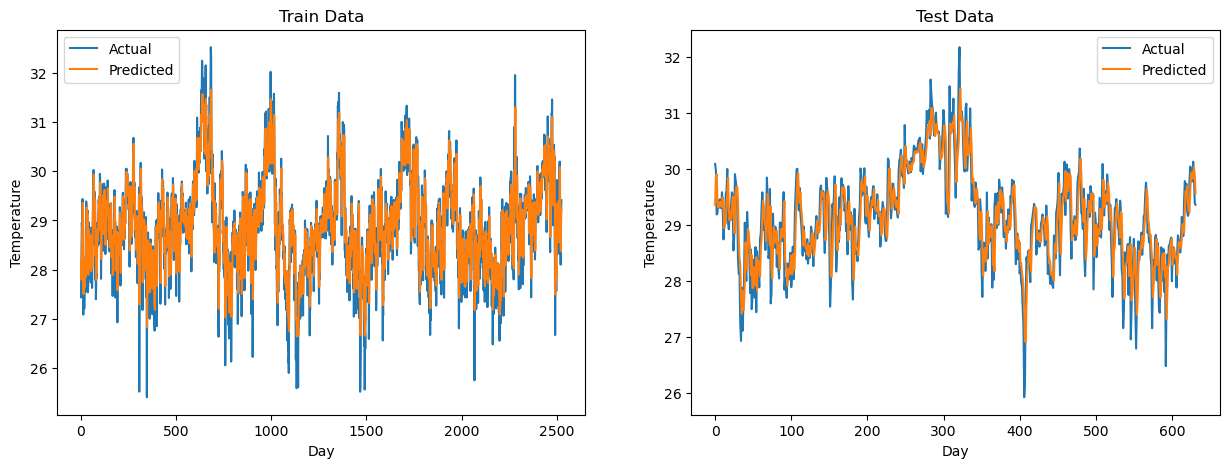

In [74]:
# Plot train dan test Actual vs Predicted
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(train_actual, label='Actual')
ax[0].plot(train_predictions, label='Predicted')
ax[0].set_title('Train Data')
ax[0].set_xlabel('Day')
ax[0].set_ylabel('Temperature')
ax[0].legend()

ax[1].plot(test_actual, label='Actual')
ax[1].plot(test_predictions, label='Predicted')
ax[1].set_title('Test Data')
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Temperature')
ax[1].legend()